# Titanic - Machine Learning from Disaster

This notebook provides a solution to the Kaggle exercise *Titanic - Machine Learning from Disaster*, where the task is to predict which passengers survived the Titanic shipwreck. The goal of this solution is not to achieve the best model accuracy, but rather demonstrate the thinking process of how a typical machine learning problem should be approached.

That process consists of the following steps:
1. Understanding the data (histograms, bar plots, etc)
2. Data cleaning
3. Feature engineering
4. Data encoding
5. Model training
6. Model tuning
7. Feature importance

## 1. Understanding the data
The first step is to understand the data. What does it look like? What features/variable does it have? Is it possible to plot the data and try to make sense of what's going on? Would it need any cleanup? Does it have any None/NaNs? Would it be possible to feature engineer more data? This is the following code aims to answer.

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from typing import List
import math
import inflection
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [179]:
# Load training and test data
train = pd.read_csv("titanic/data/csv/train.csv")
test = pd.read_csv("titanic/data/csv/test.csv")

# Combine train and test data into one DataFrame, and mark its type in a new column "is_train"
train["is_train"] = 1
test["is_train"] = 0
all_data = pd.concat([train, test])

def get_train(df: pd.DataFrame) -> pd.DataFrame:
    """Get only the training data from <df>."""
    return df[df["is_train"] == 1]

# Display the data
display(all_data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [180]:
# Convert CamelCase columns to snake_case
all_data.columns = [inflection.underscore(col) for col in all_data.columns]

# Rename columns to be more understandable
rename_cols = {
    "pclass": "person_class",
    "sib_sp": "siblings_spouses",
    "parch": "parents_children",
    "fare": "ticket_price",
}
all_data = all_data.rename(columns=rename_cols)

# Rename values to more be understandable
rename_values = {
    "person_class": {
        1: "upper",
        2: "middle",
        3: "lower",
    },
    "embarked": {
        "C": "cherbourg",
        "Q": "queenstown",
        "S": "southampton",
    },
}
for col, rename in rename_values.items():
    for from_, to in rename.items():
        all_data.loc[all_data[col] == from_, col] = to

In [181]:
# Display initial info of the dataset
display(get_train(all_data))
display(get_train(all_data).info())
display(get_train(all_data).describe().round(1))

,passenger_id,survived,person_class,name,sex,age,siblings_spouses,parents_children,ticket,ticket_price,cabin,embarked,is_train
0,1,0.0,lower,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,southampton,1
1,2,1.0,upper,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,cherbourg,1
2,3,1.0,lower,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,southampton,1
3,4,1.0,upper,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,southampton,1
4,5,0.0,lower,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,southampton,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,middle,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,southampton,1
887,888,1.0,upper,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,southampton,1
888,889,0.0,lower,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,southampton,1
889,890,1.0,upper,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,cherbourg,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   passenger_id      891 non-null    int64  
 1   survived          891 non-null    float64
 2   person_class      891 non-null    object 
 3   name              891 non-null    object 
 4   sex               891 non-null    object 
 5   age               714 non-null    float64
 6   siblings_spouses  891 non-null    int64  
 7   parents_children  891 non-null    int64  
 8   ticket            891 non-null    object 
 9   ticket_price      891 non-null    float64
 10  cabin             204 non-null    object 
 11  embarked          889 non-null    object 
 12  is_train          891 non-null    int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 97.5+ KB


None

,passenger_id,survived,age,siblings_spouses,parents_children,ticket_price,is_train
count,891.0,891.0,714.0,891.0,891.0,891.0,891.0
mean,446.0,0.4,29.7,0.5,0.4,32.2,1.0
std,257.4,0.5,14.5,1.1,0.8,49.7,0.0
min,1.0,0.0,0.4,0.0,0.0,0.0,1.0
25%,223.5,0.0,20.1,0.0,0.0,7.9,1.0
50%,446.0,0.0,28.0,0.0,0.0,14.5,1.0
75%,668.5,1.0,38.0,1.0,0.0,31.0,1.0
max,891.0,1.0,80.0,8.0,6.0,512.3,1.0


### 1.1 Understanding the data - Numerical values
In order to plot the data properly, it needs to be separated into numerical variables and categorical variables. Numerical variables can be plotted using histograms, and categorical variables using bar plots. It is also a good idea within the same plots, also group the data by its target label, whether the passengers survived or not. This gives a better understanding of what causes someone to survive or not.

As seen in the histograms of the numerical variables, the survival rate seems to be largest in people that:
- Were slightly younger
- Had parents/children
- Paid a larger ticket price

In [182]:
# Separate numerical & categorical variables to easier visualize them
cols_num = ["age", "siblings_spouses", "parents_children", "ticket_price"]
cols_cat = ["person_class", "sex", "ticket", "cabin", "embarked"]

In [183]:
# Functions for plotting numerical variables using histograms, and categorical variables using bar plots
def plot_numerical(df: pd.DataFrame, columns: List[str], group_by: str):
    """"""
    for i, col in enumerate(columns):
        plt.figure(figsize=(8,4))
        sns.histplot(
            data=df,
            bins=10,
            multiple="stack",
            x=col,
            hue=group_by,
            edgecolor=(0, 0, 0, 0),
        )
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()
        
        df_ = pd.pivot_table(df, index=group_by, values=col).round(1)
        df_.columns = ["avg_" + col for col in df_.columns]
        display(df_)
        
def plot_categorical(df: pd.DataFrame, columns: List[str], group_by: str):
    """"""
    for i, col in enumerate(columns):
        df_survived = (
            df.groupby(col)[group_by]
            .value_counts()
            .unstack(level=1)
            .sort_values(by=[0, 1], ascending=False, na_position="last")
        )
        df_survived.plot.bar(stacked=True, title=col, rot=0, xlabel="", figsize=(8,4))
        plt.show()
        
        df_survived.columns.name = "%_" + df_survived.columns.name
        df_survived = df_survived.T
        for col_ in df_survived.columns:
            df_survived[col_] = df_survived[col_] / df_survived[col_].sum()
        display(df_survived.round(2))

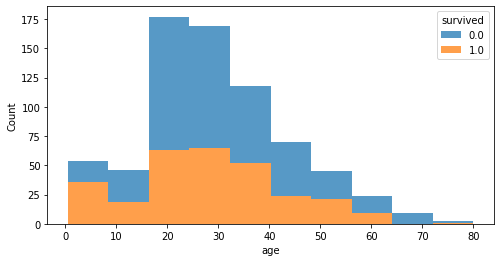

,avg_age
survived,
0.0,30.6
1.0,28.3


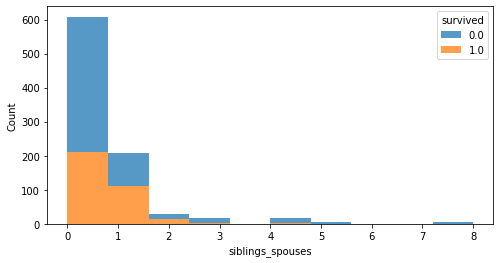

,avg_siblings_spouses
survived,
0.0,0.6
1.0,0.5


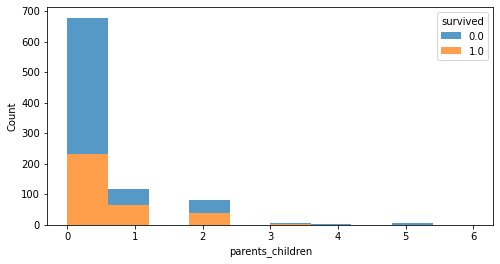

,avg_parents_children
survived,
0.0,0.3
1.0,0.5


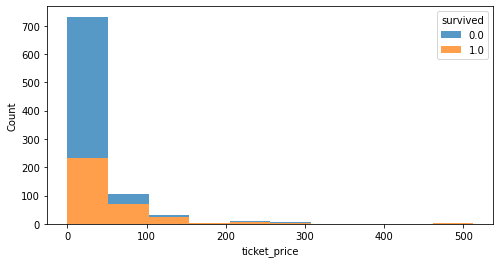

,avg_ticket_price
survived,
0.0,22.1
1.0,48.4


In [184]:
# Survival histogram distribution of all numerical variables
plot_numerical(get_train(all_data), columns=cols_num, group_by="survived")

<AxesSubplot:>

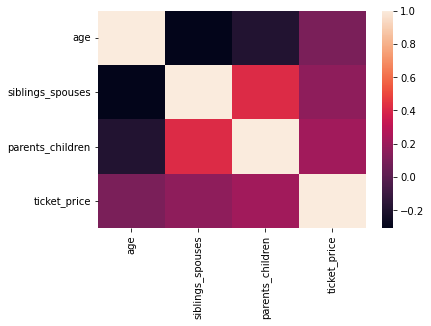

In [185]:
# Correlation matrix between numerical variables
# Shows high correlation in families travelling together, which could affect the model's performance
# negatively due to multicollinearity.
sns.heatmap(get_train(all_data)[cols_num].corr())

### 1.2 Understanding the data - Categorical values
Unlike the numerical variables, the categorical variables cannot be plotted using histograms. Instead bar plots is a more suitable alternative. Again also grouping the data by the target label whether the passengers survived or not.

This shows the survival rate was largest in people that were:
- Higher in socio-economic class
- Female
- Embarked from Cherbourg

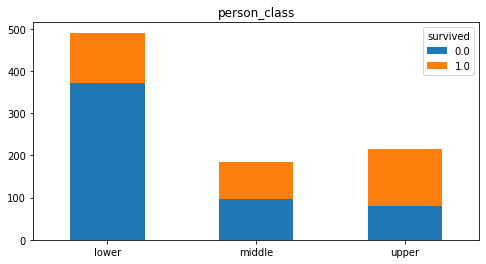

person_class,lower,middle,upper
%_survived,,,
0.0,0.76,0.53,0.37
1.0,0.24,0.47,0.63


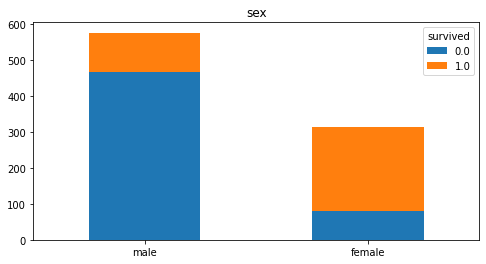

sex,male,female
%_survived,,
0.0,0.81,0.26
1.0,0.19,0.74


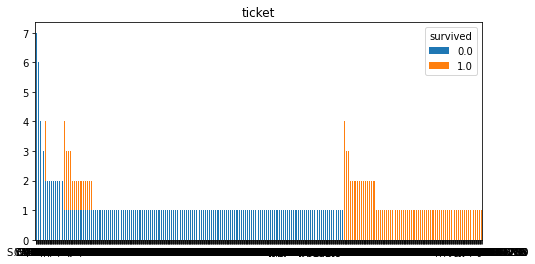

ticket,347082,CA. 2343,3101295,347088,CA 2144,382652,S.O.C. 14879,349909,4133,W./C. 6608,...,SOTON/OQ 392089,STON/O 2. 3101269,STON/O 2. 3101285,STON/O 2. 3101286,STON/O 2. 3101288,STON/O 2. 3101289,STON/O2. 3101282,STON/O2. 3101283,SW/PP 751,W./C. 14258
%_survived,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


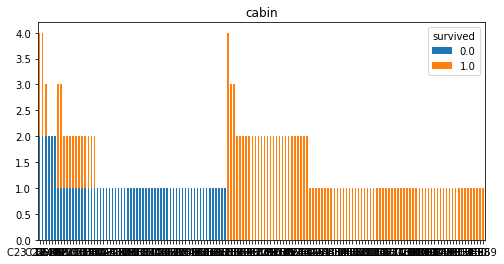

cabin,C23 C25 C27,G6,C22 C26,C124,D26,F G73,D,F2,B22,B51 B53 B55,...,E10,E12,E17,E34,E36,E40,E49,E50,E68,F E69
%_survived,,,,,,,,,,,,,,,,,,,,,
0.0,0.5,0.5,0.67,1.0,1.0,1.0,0.33,0.33,0.5,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,0.5,0.5,0.33,NaN,NaN,NaN,0.67,0.67,0.5,0.5,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


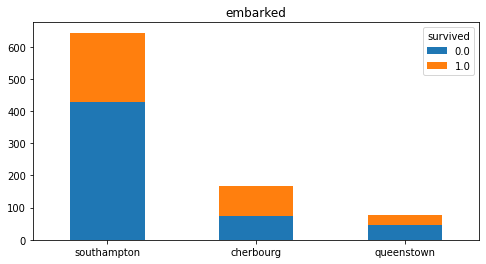

embarked,southampton,cherbourg,queenstown
%_survived,,,
0.0,0.66,0.45,0.61
1.0,0.34,0.55,0.39


In [186]:
# Survival distribution of each categorical variable
plot_categorical(get_train(all_data), columns=cols_cat, group_by="survived")

## 2. Data cleanup
The next step is to clean up the messy parts in the data. For example, some cabins seems to have multiple cabin ids appended to eachother, which just causes unnecessary noise. Some values are also None/NaN, which also have to be removed, or replaced with something else.

In [187]:
# Raw cabin data, which looks a bit messy. Let's clean it up.
set(get_train(all_data)["cabin"])

{'A10',
 'A14',
 'A16',
 'A19',
 'A20',
 'A23',
 'A24',
 'A26',
 'A31',
 'A32',
 'A34',
 'A36',
 'A5',
 'A6',
 'A7',
 'B101',
 'B102',
 'B18',
 'B19',
 'B20',
 'B22',
 'B28',
 'B3',
 'B30',
 'B35',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B49',
 'B5',
 'B50',
 'B51 B53 B55',
 'B57 B59 B63 B66',
 'B58 B60',
 'B69',
 'B71',
 'B73',
 'B77',
 'B78',
 'B79',
 'B80',
 'B82 B84',
 'B86',
 'B94',
 'B96 B98',
 'C101',
 'C103',
 'C104',
 'C106',
 'C110',
 'C111',
 'C118',
 'C123',
 'C124',
 'C125',
 'C126',
 'C128',
 'C148',
 'C2',
 'C22 C26',
 'C23 C25 C27',
 'C30',
 'C32',
 'C45',
 'C46',
 'C47',
 'C49',
 'C50',
 'C52',
 'C54',
 'C62 C64',
 'C65',
 'C68',
 'C7',
 'C70',
 'C78',
 'C82',
 'C83',
 'C85',
 'C86',
 'C87',
 'C90',
 'C91',
 'C92',
 'C93',
 'C95',
 'C99',
 'D',
 'D10 D12',
 'D11',
 'D15',
 'D17',
 'D19',
 'D20',
 'D21',
 'D26',
 'D28',
 'D30',
 'D33',
 'D35',
 'D36',
 'D37',
 'D45',
 'D46',
 'D47',
 'D48',
 'D49',
 'D50',
 'D56',
 'D6',
 'D7',
 'D9',
 'E10',
 'E101',
 'E12',
 

In [188]:
# Remove cabins with multiple cabin names in one, as that makes no sense (noise). Instead keep only the
# first cabin name if it is a multiple. Example "C23 C25 C27" -> "C23"
all_data["cabin"] = [cabin.split(" ")[0] if isinstance(cabin, str) else cabin for cabin in all_data["cabin"]]
set(get_train(all_data)["cabin"])

{'A10',
 'A14',
 'A16',
 'A19',
 'A20',
 'A23',
 'A24',
 'A26',
 'A31',
 'A32',
 'A34',
 'A36',
 'A5',
 'A6',
 'A7',
 'B101',
 'B102',
 'B18',
 'B19',
 'B20',
 'B22',
 'B28',
 'B3',
 'B30',
 'B35',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B49',
 'B5',
 'B50',
 'B51',
 'B57',
 'B58',
 'B69',
 'B71',
 'B73',
 'B77',
 'B78',
 'B79',
 'B80',
 'B82',
 'B86',
 'B94',
 'B96',
 'C101',
 'C103',
 'C104',
 'C106',
 'C110',
 'C111',
 'C118',
 'C123',
 'C124',
 'C125',
 'C126',
 'C128',
 'C148',
 'C2',
 'C22',
 'C23',
 'C30',
 'C32',
 'C45',
 'C46',
 'C47',
 'C49',
 'C50',
 'C52',
 'C54',
 'C62',
 'C65',
 'C68',
 'C7',
 'C70',
 'C78',
 'C82',
 'C83',
 'C85',
 'C86',
 'C87',
 'C90',
 'C91',
 'C92',
 'C93',
 'C95',
 'C99',
 'D',
 'D10',
 'D11',
 'D15',
 'D17',
 'D19',
 'D20',
 'D21',
 'D26',
 'D28',
 'D30',
 'D33',
 'D35',
 'D36',
 'D37',
 'D45',
 'D46',
 'D47',
 'D48',
 'D49',
 'D50',
 'D56',
 'D6',
 'D7',
 'D9',
 'E10',
 'E101',
 'E12',
 'E121',
 'E17',
 'E24',
 'E25',
 'E31',
 'E33',
 'E3

In [189]:
# Replace NaN values with the column average to make the data continuous
columns = ["age"]
for col in columns:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

In [190]:
# Drop all NaN/None "embarked" rows, only 2 rows in this case
all_data = all_data.dropna(subset=["embarked"])

## 3. Feature engineering
In order to achieve a larger model accuracy, it is a good idea to perform feature engineering on the data. This means extracting new information with already provided data, which could potentially aid the model's performance. If the added features are unnecessary, the model will just weight them as less significant.

### 3.1 Feature engineering - Cabin letter & number extraction
By looking at the cabin data, it seems to be possible to reduce it to get fewer dimensions to encode, which is good as it avoids the curse of dimensionality. I.e. the more dimensions you add, the worse the model will perform.

Therefore, by separating the cabin ids into cabin letter and cabin number, instead of having one dimension for each unique cabin id, this reduces the amount of dimensions needed to encode this data. There seems to be only 9-10 cabin letters, although a lot more cabin numbers. So the cabin letters will be set as a categorical variable, occupying 9-10 dimensions, and the cabin number as a numerical variable, occupying just one dimension.

In [191]:
# Extract cabin letter and number from "cabin" column, and put them into their own new respective column
cabin_letters = [
    "".join(re.findall("[A-Z]+", cabin)) if isinstance(cabin, str) else cabin
    for cabin in all_data["cabin"]
]
cabin_numbers = [
    "".join(re.findall("[0-9]+", cabin)) if isinstance(cabin, str) else cabin
    for cabin in all_data["cabin"]
]

# Set nan values & empty strings as "none"
cabin_letters = [
    letter if isinstance(letter, str) and len(letter) > 0 else "none"
    for letter in cabin_letters
]
cabin_numbers = [
    number if isinstance(number, str) and len(number) > 0 else "none"
    for number in cabin_numbers
]

# Add to train dataframe, and delete the original "cabin" column
del all_data["cabin"]
all_data["cabin_letter"] = cabin_letters
all_data["cabin_number"] = cabin_numbers

In [192]:
# Replace "none" strings in "cabin_number", and cast all values in the column to integers
all_data["cabin_number"] = [
    int(val) if val != "none" else 0 for val in all_data["cabin_number"]
]

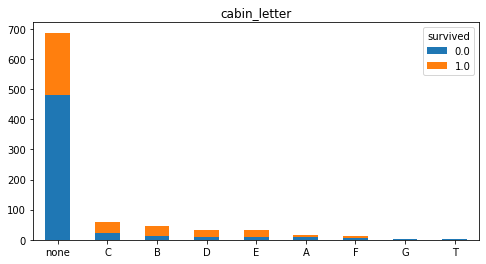

cabin_letter,none,C,B,D,E,A,F,G,T
%_survived,,,,,,,,,
0.0,0.7,0.41,0.27,0.24,0.25,0.53,0.38,0.5,1.0
1.0,0.3,0.59,0.73,0.76,0.75,0.47,0.62,0.5,NaN


In [193]:
# Survival distribution for each cabin letter.
# This shows that people who lived in cabin B, D, E and F were most likely to survive, meaning this could be a
# good feature to add.
plot_categorical(get_train(all_data), columns=["cabin_letter"], group_by="survived")

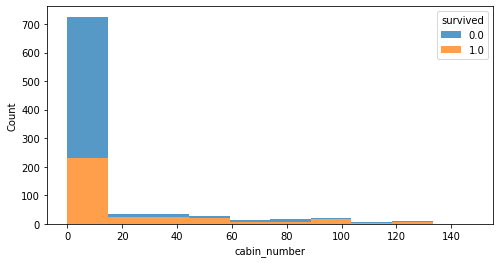

,avg_cabin_number
survived,
0.0,6.1
1.0,18.9


In [194]:
# Extract cabin number from 
train = get_train(all_data)
df = train[train["cabin_number"] != "none"].copy()
df["cabin_number"] = df["cabin_number"].to_numpy().astype(int)
plot_numerical(df, columns=["cabin_number"], group_by="survived")

### 3.2 Feature engineering - Ticket data extraction
Similarly to the cabin number and letter extraction, the ticket data could also potentially be reduced as well. However, due to lack of time, this will be skipped for now.

In [195]:
# Display ticket data
set(get_train(all_data)["ticket"])

{'110152',
 '110413',
 '110465',
 '110564',
 '110813',
 '111240',
 '111320',
 '111361',
 '111369',
 '111426',
 '111427',
 '111428',
 '112050',
 '112052',
 '112053',
 '112058',
 '112059',
 '112277',
 '112379',
 '113028',
 '113043',
 '113050',
 '113051',
 '113055',
 '113056',
 '113059',
 '113501',
 '113503',
 '113505',
 '113509',
 '113510',
 '113514',
 '113760',
 '113767',
 '113773',
 '113776',
 '113781',
 '113783',
 '113784',
 '113786',
 '113787',
 '113788',
 '113789',
 '113792',
 '113794',
 '113796',
 '113798',
 '113800',
 '113803',
 '113804',
 '113806',
 '113807',
 '11668',
 '11751',
 '11752',
 '11753',
 '11755',
 '11765',
 '11767',
 '11769',
 '11771',
 '11774',
 '11813',
 '11967',
 '12233',
 '12460',
 '12749',
 '13049',
 '13213',
 '13214',
 '13502',
 '13507',
 '13509',
 '13567',
 '13568',
 '14311',
 '14312',
 '14313',
 '14973',
 '1601',
 '16966',
 '16988',
 '17421',
 '17453',
 '17463',
 '17464',
 '17465',
 '17466',
 '17474',
 '17764',
 '19877',
 '19928',
 '19943',
 '19947',
 '19950',

### 3.3 Feature engineering - Name titles
Having one encoded dimension for each name does not make any sense, so that data will be discarded. However, there are some information that could still be good to extract before doing so, namely the name titles of the passengers. That seems to be only 17 name titles, meaning it will occupy 17 dimensions, which is ok and a lot better than all 891 unique names.

In [196]:
# Display name data
get_train(all_data)["name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: name, Length: 889, dtype: object

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

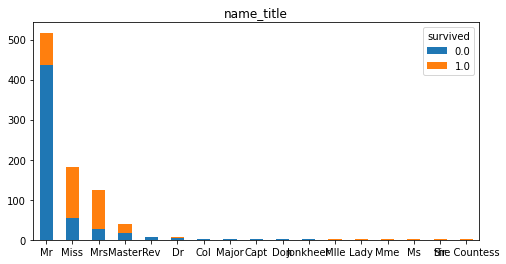

name_title,Mr,Miss,Mrs,Master,Rev,Dr,Col,Major,Capt,Don,Jonkheer,Mlle,Lady,Mme,Ms,Sir,the Countess
%_survived,,,,,,,,,,,,,,,,,
0.0,0.84,0.3,0.21,0.42,1.0,0.57,0.5,0.5,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1.0,0.16,0.7,0.79,0.57,NaN,0.43,0.5,0.5,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0


In [197]:
# Extract name titles for each name, and put them into a new "name_title" column
all_data["name_title"] = [name.split(",")[1].split(".")[0].strip() for name in all_data["name"]]
display(get_train(all_data)["name_title"].value_counts())
plot_categorical(get_train(all_data), columns=["name_title"], group_by="survived")

## 4. Data encoding
In order for the model to understand the data, it has to be encoded into a form that the model can interpret. This process is different depending on if the data has categorical or numerical variables.

The categorical variables can be encoded in different ways, but will in this case be encoded using one hot encoding. This sets a new dimension for each variable, and each variable value, that can be either 0 or 1, if it is used or not.

The numerical variables will be encoded by only having one dimension for each variable, but also normalized to be any number between 0 and 1.

In [198]:
# Extract training and test data, as well as training labels from all_data
x_train = all_data[all_data["is_train"] == 1].drop(["is_train"], axis=1)
x_test = all_data[all_data["is_train"] == 0].drop(["is_train"], axis=1)
y_train = all_data[all_data["is_train"] == 1]["survived"]

In [199]:
# One hot encode categorical features
display(all_data.columns)

cols_encode = [
    "person_class",
    "sex",
    "embarked",
    "cabin_letter",
    "name_title",
]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(x_train[cols_encode])

x_train_encoded = enc.transform(x_train[cols_encode]).toarray()
x_train_encoded.shape

Index(['passenger_id', 'survived', 'person_class', 'name', 'sex', 'age',
       'siblings_spouses', 'parents_children', 'ticket', 'ticket_price',
       'embarked', 'is_train', 'cabin_letter', 'cabin_number', 'name_title'],
      dtype='object')

(889, 34)

In [200]:
# Normalize numerical features to be between 0 and 1
cols_normalize = [
    "age",
    "ticket_price",
    "cabin_number",
    "siblings_spouses",
    "parents_children",
]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(x_train[cols_normalize])
x_train_encoded = np.hstack((scaled_values, x_train_encoded))

x_train_encoded.shape

(889, 39)

# 5. Model training
Given the encoded data, it is now possible to train the model. In this case, SVC (Support Vector Classification), KNN (K-Nearest Neighbors) and Logistic Regression will be evalutated. There are possibly other more suitable models to this problem, but these three will do for now.

In [205]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Models that will be evalutated
models = {
    "svc": SVC(),
    "knn": KNeighborsClassifier(),
    "logistic_regression": LogisticRegression(),
}

# Train and plot cross validation score for each model
for name, model in models.items():
    score = cross_val_score(model, x_train_encoded, y_train, cv=5)
    print(f"{name}: {round(score.mean(),2)}")

svc: 0.82
knn: 0.83
logistic_regression: 0.82


# 6. Model tuning
By tuning the models' parameters, it might be possible to achieve even better accuracy scores. This can either be done manually, or doing it more structured using the GridSearchCV or RandomizedSearchCV classes from sklearn. These classes automatically trains all possible parameter combinations, or a random set of them, and chooses the parameter combination with best accuracy score.

In [202]:
from sklearn.model_selection import GridSearchCV

In [203]:
def model_performance(model, model_name: str):
    """Plot a model's best score and parameters."""
    print(f"\n{model_name}:")
    print("Best score:", round(model.best_score_, 2))
    print("Best parameters:", model.best_params_)

# Parameter grid to perform grid search on
param_grids = {
    "svc": {
        "kernel": ["linear"],
        "C": [0.1, 1, 10, 100, 1000],
    },
    "knn": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "p": [1, 2],
    },
    "logistic_regression": {
        "max_iter": [2000],
        "penalty": ["l1", "l2"],
        "C": np.logspace(-4, 4, 20),
        "solver": ["liblinear"],
    }
}

# Perform grid parameter search on the models, and select the best performing one
for name, param_grid in param_grids.items():
    model_grid = GridSearchCV(models[name], param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
    best_model = model_grid.fit(x_train_encoded, y_train)
    model_performance(best_model, name)
    
    models[name] = best_model.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits

svc:
Best score: 0.82
Best parameters: {'C': 10, 'kernel': 'linear'}
Fitting 5 folds for each of 48 candidates, totalling 240 fits

knn:
Best score: 0.83
Best parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits

logistic_regression:
Best score: 0.83
Best parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


# 7. Feature importance
With all models finally trained, it's a good idea to plot the weights the model has for each feature, i.e. its feature importances. This might give some insight into which features seems to have a large influence on the model, and which seems to be just unnecessary noise, and could even be removed from the data.

As seen here, being female seems to be a good indicator for survival, while being older does not seem to be as good.

Feature importances: logistic_regression


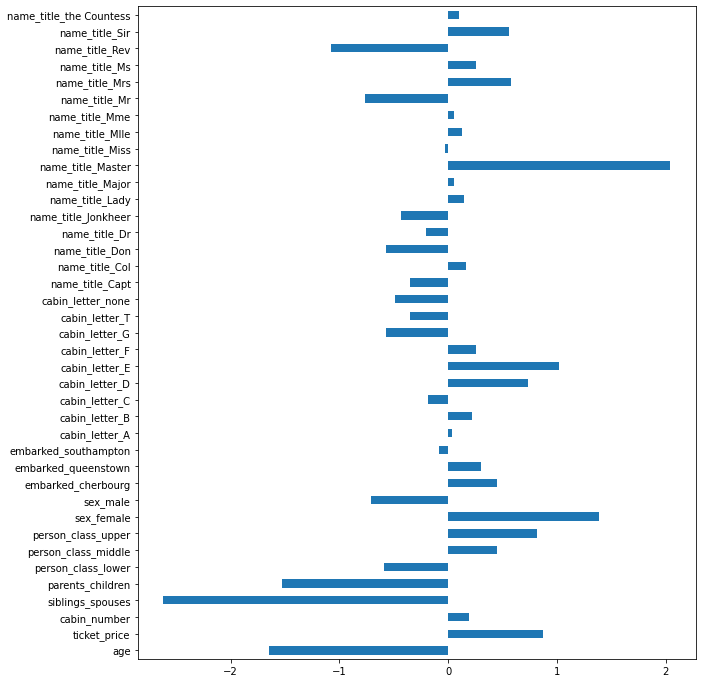

In [204]:
# Plot feature importances for each model
for name, model in models.items():
    if "coef_" in model.__dict__:
        print("Feature importances:", name)
        feature_names = list(cols_normalize) + list(enc.get_feature_names(cols_encode))
        feat_importances = pd.Series(model.coef_[0], feature_names)
        feat_importances.plot(kind="barh", figsize=(10,12))